### Importar librerías cirq y qsimcirq

In [191]:
try:
    import cirq
except ImportError:
    !pip install cirq
    import cirq

try:
    import qsimcirq
except ImportError:
    !pip install qsimcirq
    import qsimcirq

### Cargarmos el profiler scalene, para medir los tiempos

In [2]:
%load_ext scalene

LOADING
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version. To profile in line mode, use
`%scrun [options] statement`. To profile in cell mode, use `%%scalene
[options]` followed by your code.


# PORTER THOMAS

In [277]:
def porter_thomas_distribution(probabilities, n_qubits):
    N = 2**n_qubits  # Número total de estados
    Np = probabilities * N  # Rescalamos las probabilidades
    hist, bin_edges = np.histogram(Np, bins=50, density=True)  # Histograma normalizado
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Centros de los bins
    return centers, hist

In [261]:
import cirq
import qsimcirq 
import numpy as np

#patron del circuito 1D
pattern_1D = [
    cirq.experiments.GridInteractionLayer(
        col_offset=0,
        vertical=True,
        stagger=True
    ),
    cirq.experiments.GridInteractionLayer(
        col_offset=1,
        vertical=True,
        stagger=True
    )
]


#función para generar el circuito aleatorio con ruido
def random_circuits_normal(qubits, nr_layers, grid_type):
   
    if grid_type == '1D':
        circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(
            qubits=qubits,
            depth=nr_layers,
            pattern=pattern_1D,
            add_final_single_qubit_layer=False
        )
    elif grid_type == '2D':
        circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(
            qubits=qubits,
            depth=nr_layers,
            pattern=cirq.experiments.GRID_STAGGERED_PATTERN,
            add_final_single_qubit_layer=False
        )

    return circuit_google
    
#funcion para introducir ruido en el circuito
def introduce_noise(circuit, qubits, error, error_type):
    #qubits = [cirq.GridQubit(i, 0) for i in range(nr_qubits)]
    if error != 0:
        noisy_circuit = circuit.copy()  # Crear una copia del circuito base

        if error_type == 'depolarization':
            capa = 1
            while capa < len(noisy_circuit):
                random_layer = cirq.Moment(
                        np.random.choice([cirq.X, cirq.Y, cirq.Z])(q) if np.random.rand() < error else cirq.I(q)
                        for q in qubits
                    )
                noisy_circuit.insert(capa, random_layer)
                capa += 2  # Avanzar dos posiciones para intercalar las capas
            return noisy_circuit
        
        elif error_type == 'amplitude_damping':
            capa = 1
            while capa < len(noisy_circuit):
                random_layer = cirq.Moment(cirq.amplitude_damp(gamma=error).on(q) for q in qubits)
                noisy_circuit.insert(capa, random_layer)
                capa += 2  # Avanzar dos posiciones para intercalar las capas
            return noisy_circuit

    else:
        return circuit

#from scalene import scalene_profiler

# Inicializamos las opciones para el hardware de simulación
# Option 1 (mode=0) or Option 2 (mode=1)
# Option 3 (number of GPUs = `num_gpus`)
gpu_options = qsimcirq.QSimOptions(cpu_threads=4, use_gpu=False, gpu_mode = 0, max_fused_gate_size=4)
qsim_simulator = qsimcirq.QSimSimulator(qsim_options=gpu_options)

#-------------------------------------------------------

#valores iniciales
nr_qubits=20
nr_layers=40
repeticiones=50  #número de veces que se simula el circuito aleatorio
grid_type='1D'
epsilon = [0,0.0004, 0.001,0.003,0.01] #ruido
result = np.zeros((len(epsilon), 2**(nr_qubits)))
qubits = [cirq.GridQubit(i, 0) for i in range(nr_qubits)]
noise_type='depolarization' #depolarization or amplitude_damping

circuit = random_circuits_normal(qubits, nr_layers, grid_type)
circuit.insert(0, cirq.H.on_each(*qubits))
#print(circuit)
for r in range(repeticiones):

  for idx, e in enumerate(epsilon):
    noisy_circuit=introduce_noise(circuit, qubits, e, noise_type)
    
    #print("Circuito simulado:")
    #print(noisy_circuit)

    result[idx]+=np.abs(qsim_simulator.simulate(noisy_circuit).final_state_vector)**2 

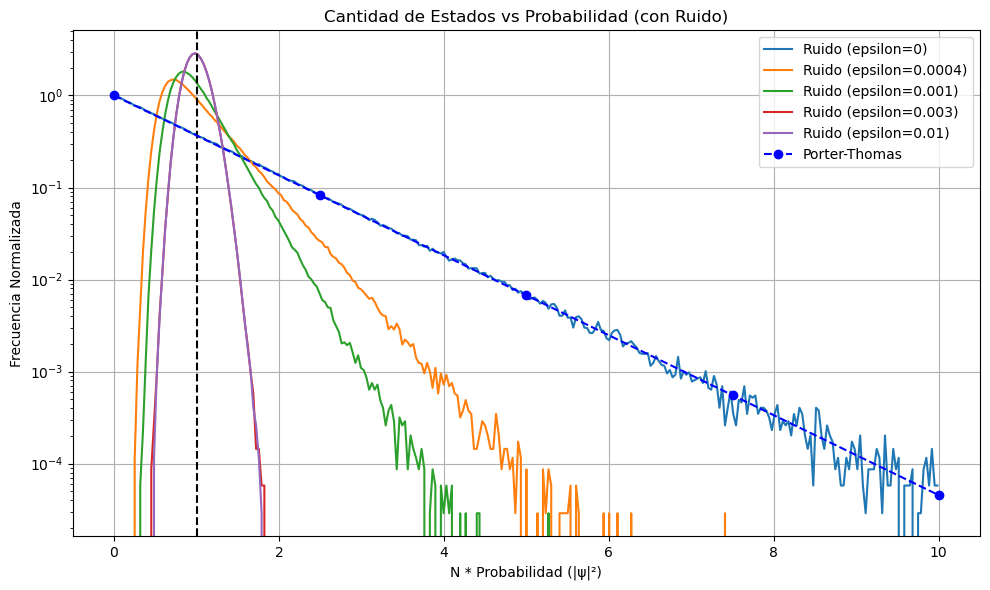

In [262]:
import numpy as np
import matplotlib.pyplot as plt

# Inicializar los parámetros
N = 2**nr_qubits  # Número total de estados
bin_edges = np.linspace(0, 10, 300)  # Dividir las probabilidades en 500 bins

# Crear el gráfico
fig=plt.figure(figsize=(10, 6))

hist, _ = np.histogram(result[0] * N/repeticiones, bins=bin_edges)  # Calcular histograma
norma=max(hist)

# Procesar los datos de `result` para cada nivel de ruido
for e, probabilities in zip(epsilon, result):
    hist, _ = np.histogram(probabilities * N/repeticiones, bins=bin_edges)  # Calcular histograma
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calcular los centros de los bins
    plt.plot(bin_centers, hist/norma, linestyle='-', label=f"Ruido (epsilon={e})")

# Configuración del gráfico
plt.title("Cantidad de Estados vs Probabilidad (con Ruido)")
plt.xlabel("N * Probabilidad (|ψ|²)")
plt.yscale('log')  # Escala logarítmica en el eje Y
plt.ylabel("Frecuencia Normalizada")
plt.grid(True)

plt.tight_layout()

#dibujo una linea vertical en x=1
plt.axvline(x=1, color='black', linestyle='--')

#pinto la recta porter thomas para comparar PT=e^(-N*P) sin usar la funcion
x = np.linspace(0, 10, 5)
y = np.exp(-x)
plt.plot(x, y, label='Porter-Thomas', marker='o', color='blue', linestyle='--')


plt.legend()
location="C:\\Users\\aileo\\environments\\TFG\\TFM\\porter_thomas"
fig.savefig(f'{location}/PT_{noise_type}_rep{repeticiones}.pdf')
plt.show()


# Mi código OTOCS 

### Funciones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cirq
import qsimcirq 


#patron del circuito 1D
pattern = [
    cirq.experiments.GridInteractionLayer(
        col_offset=0,
        vertical=True,
        stagger=True
    ),
    cirq.experiments.GridInteractionLayer(
        col_offset=1,
        vertical=True,
        stagger=True
    )
]

#funcion que añade el qubit auxiliar en q0
def ancilla(circuit: cirq.Circuit) -> cirq.Circuit:
    # Definimos un qubit ancilla, donde se mide el otoc
    anc= cirq.GridQubit(0, 0)  

    # Añadimos el qubit: una identidad sobre el ancilla en un nuevo momento 
    circuit.insert(0, cirq.I(anc))

    return circuit

#función para generar el circuito aleatorio con ruido
def random_circuits(nr_qubits, nr_layers):
   
    #qubits = cirq.GridQubit.rect(nr_qubits, 1)
    qubits = [cirq.GridQubit(i+1, 0) for i in range(nr_qubits)]
    #genero el random_circuit sin ruido con el nr_qubits y el nr_layers dados
    circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(
        qubits=qubits,
        depth=nr_layers,
        pattern=pattern,
        add_final_single_qubit_layer=False

    )

    circuit_google = ancilla(circuit_google)
    return circuit_google
    
#funcion para introducir ruido en el circuito
def introduce_noise(circuit, nr_qubits, error, error_type):
    qubits = [cirq.GridQubit(i, 0) for i in range(nr_qubits+1)]
    if error != 0:
        noisy_circuit = circuit.copy()  # Crear una copia del circuito base

        if error_type == 'depolarization':
            capa = 1
            while capa < len(noisy_circuit):
                random_layer = cirq.Moment(
                        np.random.choice([cirq.X, cirq.Y, cirq.Z])(q) if np.random.rand() < error else cirq.I(q)
                        for q in qubits
                    )
                noisy_circuit.insert(capa, random_layer)
                capa += 2  # Avanzar dos posiciones para intercalar las capas
            return noisy_circuit
        
        elif error_type == 'amplitude_damping':
            capa = 1
            while capa < len(noisy_circuit):
                random_layer = cirq.Moment(cirq.amplitude_damp(gamma=error).on(q) for q in qubits)
                noisy_circuit.insert(capa, random_layer)
                capa += 2  # Avanzar dos posiciones para intercalar las capas
            return noisy_circuit

    else:
        return circuit
    
    
    
#funcion que genera U^dagger
def inverse_circuit(circuit: cirq.Circuit) -> cirq.Circuit:
    inverse_circuit = cirq.Circuit()
    
    # Recorremos las capas (moments) en orden inverso
    for moment in reversed(circuit):
        
        inverse_ops = []
       
        # Cada operación la invertimos 
        for op in moment.operations:
            # cirq.inverse(op) produce la operación inversa si existe
            inv_op = cirq.inverse(op, None)
            inverse_ops.append(inv_op)
        
        # Añadimos la capa inversa al circuito
        inverse_circuit.append(inverse_ops)
    
    return inverse_circuit

#definimos la funcion principal, que construye el circuito para estudiar la evolucion del otoc
def OTOC_circuit(nr_qubits, nr_layers, error,error_type, O_operator, O_position, M_operator):
 
    # Creamos el circuito
    circuit = random_circuits(nr_qubits, nr_layers)

    #Calculamos el circuito inverso
    circuit_dagger=inverse_circuit(circuit)

    #Introducimos el operador que evoluciona en el tiempo O(t)
    circuit.append(O_operator(cirq.GridQubit(O_position, 0)))

    #Añadimos U^dagger
    circuit.append(circuit_dagger)

    #para la simulacion con ruido
    circuit = introduce_noise(circuit, nr_qubits, error, error_type)
    
    #Añadimos el operador M sobre q1 entrelazado con el qubit ancilla
    circuit.insert(0,M_operator(cirq.GridQubit(0, 0),cirq.GridQubit(1, 0)))
    circuit.append(M_operator(cirq.GridQubit(0, 0),cirq.GridQubit(1, 0)))

    
    circuit.insert(1, cirq.Moment())
  

    return circuit


In [2]:
nr_circuits=60
nr_layers_max=10
nr_qubits=10
error=0.008
error_type='amplitude_damping' #deporlarization or amplitude_damping

In [3]:
results = []
for O_position in range(2, nr_qubits-3):
    exp_values_medio=[]
    for nr_layers in range(1, nr_layers_max):
        total=0
        for cirqu in range(nr_circuits):
            #genero el circuito
            circuit=OTOC_circuit(nr_qubits, nr_layers, error, error_type, cirq.X, O_position, cirq.CZ)

            #inicializo los qubits
            qubits = [cirq.GridQubit(i, 0) for i in range(nr_qubits+1)]
            #qubit ancilla en +Y
            circuit.insert(0,[ cirq.H(qubits[0]),cirq.S(qubits[0])])
            #el resto en +X
            for q in qubits[1:]:
                circuit.insert(0,cirq.H(q))

            #calculo el valor esperado de pauli_y en el qubit ancilla
            ps = cirq.Y(qubits[0])  
            sim = cirq.Simulator()
            exp_values = sim.simulate_expectation_values(circuit, observables=[ps])
            #print("Valor esperado de Y =", exp_values[0])
            total+=np.real(exp_values[0])

        exp_values_medio.append(total/nr_circuits)
    results.append(exp_values_medio)

print(circuit)

(0, 0): ────H───S───@───────I───────────────AD(0.008)───────AD(0.008)───────────────────AD(0.008)───────AD(0.008)───────────────────AD(0.008)───────AD(0.008)───────────────────AD(0.008)───────AD(0.008)───────────────────AD(0.008)───────AD(0.008)───────────AD(0.008)───────AD(0.008)───────────────────AD(0.008)───────AD(0.008)───────────────────AD(0.008)───────AD(0.008)───────────────────AD(0.008)───────AD(0.008)───────AD(0.008)───I────────────────AD(0.008)────────────────────AD(0.008)───────AD(0.008)────────────────────AD(0.008)────────────────────AD(0.008)────────────────────AD(0.008)───────AD(0.008)────────────AD(0.008)────────────────────AD(0.008)────────────────────AD(0.008)───────AD(0.008)────────────────────AD(0.008)────────────────────AD(0.008)────────────────────AD(0.008)───────AD(0.008)────────────────────AD(0.008)────────────────────AD(0.008)───@────────────────
                    │                                                                                                

### sin O(t):

In [4]:
results_sin_O=[]
for nr_layers in range(1, nr_layers_max):
    total=0
    for cirqu in range(nr_circuits):
        #genero el circuito
        circuit=OTOC_circuit(nr_qubits, nr_layers, error, error_type, cirq.I, O_position, cirq.CZ)

        #inicializo los qubits
        qubits = [cirq.GridQubit(i, 0) for i in range(nr_qubits+1)]
        #qubit ancilla en +Y
        circuit.insert(0,[ cirq.H(qubits[0]),cirq.S(qubits[0])])
        #el resto en +X
        for q in qubits[1:]:
            circuit.insert(0,cirq.H(q))

        #calculo el valor esperado de pauli_y en el qubit ancilla
        ps = cirq.Y(qubits[0])  
        sim = cirq.Simulator()
        exp_values = sim.simulate_expectation_values(circuit, observables=[ps])
        #print("Valor esperado de Y =", exp_values[0])
        total+=np.real(exp_values[0])

    results_sin_O.append(total/nr_circuits)

#print(results_sin_O)
#print(circuit)

### Plot < Y >

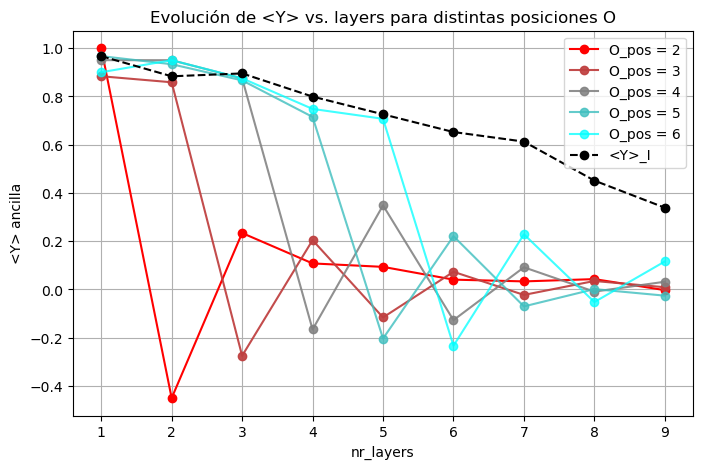

In [6]:
fig=plt.figure(figsize=(8,5))

xvals = range(1, nr_layers_max)
color_param=1.0/(O_position-2)

for idx, yvals in enumerate(results):
    # O_position real = 2 + idx
    label_str = f"O_pos = {2 + idx}"
    color = (1.0-idx*color_param, 0.0 + idx * color_param, 0.0 + idx*color_param, 1 - idx * color_param/4)
    plt.plot(xvals, yvals, 'o-',color=color, label=label_str)


plt.plot(xvals, results_sin_O, 'o--',color=(0.0, 0, 0.0, 1 ), label="<Y>_I")

plt.xlabel("nr_layers")
plt.ylabel("<Y> ancilla")
plt.title("Evolución de <Y> vs. layers para distintas posiciones O")
plt.grid(True)
plt.legend()
location="C:\\Users\\aileo\\environments\\TFG\\TFM\\OTOCS"
if error==0:
    fig.savefig(f'{location}/otoc_Y_q{nr_qubits}_e{error}_c{nr_circuits}_fig1C-Apaper.pdf')
else:
    fig.savefig(f'{location}/otoc_Y_q{nr_qubits}_{error_type}_e{error}_c{nr_circuits}_fig1C-Apaper.pdf')
plt.show()

### Plot < Y >/< Y >_I

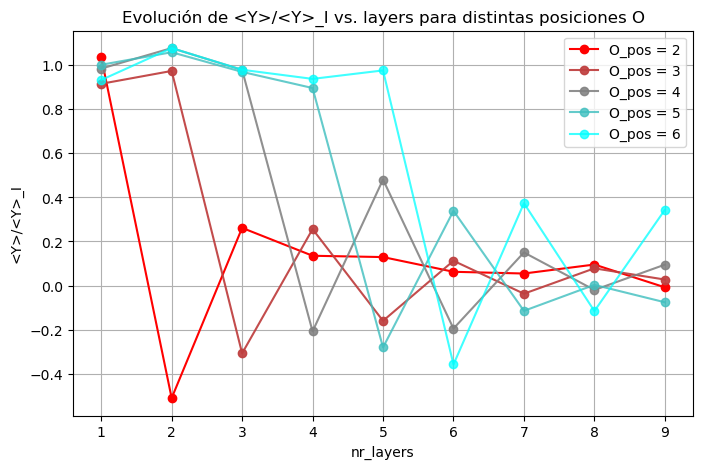

In [8]:
fig=plt.figure(figsize=(8,5))

xvals = range(1, nr_layers_max)
color_param=1.0/(O_position-2)

for idx, yvals in enumerate(results):
    # O_position real = 2 + idx
    label_str = f"O_pos = {2 + idx}"
    color = (1.0-idx*color_param, 0.0 + idx * color_param, 0.0 + idx*color_param, 1 - idx * color_param/4)
    plt.plot(xvals, [y / rs for y, rs in zip(yvals, results_sin_O)], 'o-', color=color, label=label_str)


plt.xlabel("nr_layers")
plt.ylabel("<Y>/<Y>_I")
plt.title("Evolución de <Y>/<Y>_I vs. layers para distintas posiciones O")
plt.grid(True)
plt.legend()
location="C:\\Users\\aileo\\environments\\TFG\\TFM\\OTOCS"
if error==0:
    fig.savefig(f'{location}/otoc_Y_q{nr_qubits}_e{error}_c{nr_circuits}_fig1C-Bpaper.pdf')
else:
    fig.savefig(f'{location}/otoc_Y_q{nr_qubits}_{error_type}_e{error}_c{nr_circuits}_fig1C-Bpaper.pdf')
plt.show()

# Código OTOCS paper Filipa

In [175]:
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import cirq
import qsimcirq 

def random_circuits(nr_qubits, nr_layers, error):
    """Function that evolves the state of a randomly created quantum
    circuit with nr_qubits qubits and nr_layers layers, and gates
    drawn from a gate set defined by gate_set.

    Luego se le aplica cierto nivel de ruido a cada capa del circuito.

    Args:
        nr_qubits (int): Number of qubits in the quantum circuit
        nr_layers (int): Number of layers responsible for the state
        evolution
        error (float): error
    Returns:
        QuantumCircuit: The corresponding quantum circuit
    """
    qubits = cirq.GridQubit.rect(nr_qubits, 1)
    #genero el random_circuit sin ruido con el nr_qubits y el nr_layers dados
    circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(qubits=qubits, depth=nr_layers)

    if error != 0:
        noisy_circuit = circuit_google.copy()  # Crear una copia del circuito base
        capa = 1
        while capa < len(noisy_circuit):
            random_layer = cirq.Moment(
                    np.random.choice([cirq.X, cirq.Y, cirq.Z])(q) if np.random.rand() < error else cirq.I(q)
                    for q in qubits
                )
            noisy_circuit.insert(capa, random_layer)
            capa += 2  # Avanzar dos posiciones para intercalar las capas
        return noisy_circuit

    else:
        return circuit_google

   

def kron_product(nr_qubits, Op):
    """Function for making the scrambling operators.

    Args:
        nr_qubits (int): Number of qubits
        Op (np.array): The numpy array defining a given operator

    Returns:
        np.array: A numpy array which describes the scrambled
        version of Op
    """
    Identity = np.eye(Op.shape[0])
    result = Op
    for _ in range(nr_qubits - 1):
        result = np.kron(result, Identity)
    return result

def otoc(U_op, V_op, W_op, dens_mat):
    """Function to calculate the OTOC

    Args:
        U_op (np.array): Circuit unitary
        V_op (np.array): V of the otoc
        W_op (np.array): W of the otoc (butterfly operator)
        dens_mat (np.array): Circuit input state

    Returns:
        complex: The complex-valued F(t)
    """
    # Evolution of the operator W under the unitary dynamics U
    W_t = np.dot(np.dot(np.transpose(np.conjugate(U_op)), W_op), U_op)

    # OTOC
    F_t = np.trace(
        np.transpose(np.conjugate(W_t)) @ np.transpose(np.conjugate(V_op))
        @ W_t @ V_op @ dens_mat)
    return F_t


def execute_code(nr_qubits,
                 nr_layers,
                 nr_circuits,
                 t_steps,
                 error,
                 location
                 ):

    """Main function that runs the entire code.

    Args:
        nr_qubits (int): Number of qubits
        nr_layers (int): Number of layers between each otoc evaluation
        nr_circuits (int): Number of circuits
        error (float): Desired gate set
        t_steps (int): Number of time steps to consider (i.e. number
        of otoc evaluations)
        inj_times (list[int]): Injection times (i.e., times where we
        inject the cat gadget)
        location (str): Path to where we store the data and plots
        rand (bool, opt): If we are to use randomly generated layers
        or only pseudo-random layers
        flagh (bool, opt): If rand is False, then we need to decide
        if each of the non-randomly chosen Hadamrd layers are created
        in a random way (if True) or are complete (if False)
        flags (bool, opt): If rand is False, then we need to decide
        if each of the non-randomly chosen phase layers are created
        in a random way (if True) or are complete (if False)
    """
    dimension_HS = 2**nr_qubits
    with open(f'{location}/Time_steps.txt', 'w') as data_file:
        json.dump(list(range(t_steps)), data_file)

    # Define the initial state rho
    rho = np.zeros((dimension_HS, dimension_HS))
    rho[0, 0] = 1
   
    # Define the operators V and W
    PauliX = np.array([[0, 1], [1, 0]])
    PauliY = np.array([[0, -1j], [1j, 0]])
    PauliZ = np.array([[1, 0], [0, -1]])
    Pauli_plus=1/2*(PauliX+1j*PauliY)
    #V = kron_product(nr_qubits, PauliX)
    V = kron_product(nr_qubits, PauliX)
    #W = np.kron(kron_product(nr_qubits - 1, np.eye(2)), Pauli_plus) #separados
    W = np.kron(np.eye(2),kron_product(nr_qubits-1, Pauli_plus)) #juntos
    # For making a single plot
    F_total_re = []
    #F_total_im = []
    F_total= []
    qubits = cirq.GridQubit.rect(nr_qubits, 1)
    
    for circ in range(nr_circuits):
        # Create two quantum circuit variables:
        circuit = cirq.Circuit(cirq.I(q) for q in qubits)
        block = cirq.Circuit()
        F_values_re = []
        #F_values_im = []
        F_values= []
        save_circ = ""
       
        for t in range(t_steps):
            
            U = cirq.unitary(circuit)
            F_values_re.append(otoc(U, V, W, rho).real)
            #F_values_im.append(otoc(U, V, W, rho).imag)
            F_values.append(np.abs(otoc(U, V, W, rho)))
    
            block = random_circuits(nr_qubits, nr_layers, error)
            save_circ += cirq.qasm(block)
            circuit.append(block, [*range(nr_qubits)])


        # Saving the data for each circuit:
        with open(f'{location}/Circuit{circ}.txt', 'w') as circ_file:
            circ_file.write(save_circ)
        with open(f'{location}/Circuit{circ}-ReF.txt', 'w') as data_file:
            json.dump(F_values_re, data_file)
        #with open(f'{location}/Circuit{circ}-ImF.txt', 'w') as data_file:
            #json.dump(F_values_im, data_file)
        # Append F_values_re and _im into total
        F_total_re.append(F_values_re)
        #F_total_im.append(F_values_im)
        F_total.append(F_values)
        
        # Plotting 
        fig = plt.figure(figsize=(12, 8))
        plt.title('Out-of-time-order correlator', fontsize=20)
        plt.xlabel(r"$t$", fontsize=14)
        plt.ylabel(r"$F(t)$", fontsize=14)
        plt.ylim(-1.05, 1.05)

        plt.plot(list(range(t_steps)),
                 F_values_re,
                 '-o',
                 color='blue',
                 label=r"$\mathfrak{R}(F(t))$")
        """
        plt.plot(list(range(t_steps)),
                 F_values_im,
                 '-o',
                 color='red',
                 markerfacecolor='white',
                 label=r"$\mathfrak{I}(F(t))$")
        """
        plt.legend(fontsize=14, loc="best")
        plt.tight_layout()
        fig.savefig(f'{location}/Plot-Circuit{circ}.pdf')
        plt.close()

    #Plotting the total plot
    fig = plt.figure(figsize=(12, 8))
    plt.title('Out-of-time-order correlator', fontsize=30)
    plt.xlabel(r"$\tau$", fontsize=30)
    plt.ylabel(r"$\mathfrak{R}[F(\tau)]$", fontsize=30)
    #plt.ylim(-0.3, 1.05)
    plt.ylim(-1.05, 2.05)
    # Set the size of the tick labels for both the x and y axes
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    highlight=0
    for F_values_re in F_total_re:
        if highlight == nr_circuits - 1:
            plt.plot(list(range(t_steps)),
                 F_values_re,
                 '-o',
                 color='blue')
        if highlight <= nr_circuits - 2:
            plt.plot(list(range(t_steps)),
                 F_values_re,
                 '-o',
                 color='#aec2d1')
            highlight+=1
    #plt.legend(fontsize=25, loc="best")
    plt.tight_layout()
    fig.savefig(f'{location}/Plot-Circuit-Total.pdf')
    plt.close()
    

<>:180: SyntaxWarning: invalid escape sequence '\m'
<>:180: SyntaxWarning: invalid escape sequence '\m'
C:\Users\aileo\AppData\Local\Temp\ipykernel_34488\122252036.py:180: SyntaxWarning: invalid escape sequence '\m'
  """


In [176]:
#valores iniciales
nr_qubits=7
nr_layers=2
nr_circuits=10
t_steps=30
error = 0.00
save = "C:\\Users\\aileo\\environments\\TFG\\TFM\\OTOCS\\epsilon_0.1"
 # Inicializamos las opciones para el hardware de simulación
# Option 1 (mode=0) or Option 2 (mode=1)
# Option 3 (number of GPUs = `num_gpus`)
gpu_options = qsimcirq.QSimOptions(cpu_threads=4, use_gpu=False, gpu_mode = 0, max_fused_gate_size=4)
qsim_simulator = qsimcirq.QSimSimulator(qsim_options=gpu_options)

#-------------------------------------------------------



execute_code(nr_qubits, nr_layers, nr_circuits,  t_steps, error, save)

## Modificación 


In [ ]:
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import cirq
import qsimcirq 

def random_circuits(nr_qubits, nr_layers, error):
   
    qubits = cirq.GridQubit.rect(nr_qubits, 1)
    #genero el random_circuit sin ruido con el nr_qubits y el nr_layers dados
    circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(qubits=qubits, depth=nr_layers)

    if error != 0:
        noisy_circuit = circuit_google.copy()  # Crear una copia del circuito base
        capa = 1
        while capa < len(noisy_circuit):
            random_layer = cirq.Moment(
                    np.random.choice([cirq.X, cirq.Y, cirq.Z])(q) if np.random.rand() < error else cirq.I(q)
                    for q in qubits
                )
            noisy_circuit.insert(capa, random_layer)
            capa += 2  # Avanzar dos posiciones para intercalar las capas
        return noisy_circuit

    else:
        return circuit_google

   

def kron_product(nr_qubits, Op):
    """Function for making the scrambling operators.

    Args:
        nr_qubits (int): Number of qubits
        Op (np.array): The numpy array defining a given operator

    Returns:
        np.array: A numpy array which describes the scrambled
        version of Op
    """
    Identity = np.eye(Op.shape[0])
    result = Op
    for _ in range(nr_qubits - 1):
        result = np.kron(result, Identity)
    return result

def otoc(U_op, V_op, W_op, dens_mat):
    """Function to calculate the OTOC

    Args:
        U_op (np.array): Circuit unitary
        V_op (np.array): V of the otoc
        W_op (np.array): W of the otoc (butterfly operator)
        dens_mat (np.array): Circuit input state

    Returns:
        complex: The complex-valued F(t)
    """
    # Evolution of the operator W under the unitary dynamics U
    W_t = np.dot(np.dot(np.transpose(np.conjugate(U_op)), W_op), U_op)

    # OTOC
    F_t = np.trace(
        np.transpose(np.conjugate(W_t)) @ np.transpose(np.conjugate(V_op))
        @ W_t @ V_op @ dens_mat)
    return F_t


def execute_code(nr_qubits,
                 nr_layers,
                 nr_circuits,
                 t_steps,
                 error,
                 location
                 ):

    """Main function that runs the entire code.

    Args:
        nr_qubits (int): Number of qubits
        nr_layers (int): Number of layers between each otoc evaluation
        nr_circuits (int): Number of circuits
        error (float): Desired gate set
        t_steps (int): Number of time steps to consider (i.e. number
        of otoc evaluations)
        inj_times (list[int]): Injection times (i.e., times where we
        inject the cat gadget)
        location (str): Path to where we store the data and plots
        rand (bool, opt): If we are to use randomly generated layers
        or only pseudo-random layers
        flagh (bool, opt): If rand is False, then we need to decide
        if each of the non-randomly chosen Hadamrd layers are created
        in a random way (if True) or are complete (if False)
        flags (bool, opt): If rand is False, then we need to decide
        if each of the non-randomly chosen phase layers are created
        in a random way (if True) or are complete (if False)
    """
    dimension_HS = 2**nr_qubits
    with open(f'{location}/Time_steps.txt', 'w') as data_file:
        json.dump(list(range(t_steps)), data_file)

    # Define the initial state rho
    #rho = np.zeros((dimension_HS, dimension_HS))
    #rho[0, 0] = 1
   
    # Define the operators V and W
    #PauliX = np.array([[0, 1], [1, 0]])
    #PauliZ = np.array([[1, 0], [0, -1]])
    #V = kron_product(nr_qubits, PauliX)
    #V = kron_product(nr_qubits, PauliZ)
    #W = np.kron(kron_product(nr_qubits - 1, np.eye(2)), PauliZ)
    #W = kron_product(nr_qubits, PauliZ)
    # For making a single plot
    F_total_re = []
    #F_total_im = []
    F_total= []
    qubits = cirq.GridQubit.rect(nr_qubits, 1)
    
    for circ in range(nr_circuits):
        # Create two quantum circuit variables:
        circuit_t = cirq.Circuit()
        block = cirq.Circuit()
        F_values_re = []
        #F_values_im = []
        F_values= []
        save_circ = ""
       
        for t in range(t_steps):
            
            circuit = cirq.Circuit(cirq.Z(int(nr_qubits/2)))
            block = random_circuits(nr_qubits, nr_layers, error)
            #save_circ += cirq.qasm(block)
            circuit_t.append(block,[*range(nr_qubits)])
            
            circuit.append(circuit_t, [*range(nr_qubits)])
            circuit.append(cirq.Z(int(nr_qubits/2)))
            circuit.append(cirq.inverse(circuit_t), [*range(nr_qubits)])
            result[t]=np.abs(qsim_simulator.simulate(circuit).final_state_vector)**2

        # Saving the data for each circuit:
        with open(f'{location}/Circuit{circ}.txt', 'w') as circ_file:
            circ_file.write(save_circ)
        with open(f'{location}/Circuit{circ}-ReF.txt', 'w') as data_file:
            json.dump(F_values_re, data_file)
        #with open(f'{location}/Circuit{circ}-ImF.txt', 'w') as data_file:
            #json.dump(F_values_im, data_file)
        # Append F_values_re and _im into total
        F_total_re.append(F_values_re)
        #F_total_im.append(F_values_im)
        F_total.append(F_values)
        
        # Plotting 
        fig = plt.figure(figsize=(12, 8))
        plt.title('Out-of-time-order correlator', fontsize=20)
        plt.xlabel(r"$t$", fontsize=14)
        plt.ylabel(r"$F(t)$", fontsize=14)
        plt.ylim(-1.05, 1.05)

        plt.plot(list(range(t_steps)),
                 F_values_re,
                 '-o',
                 color='blue',
                 label=r"$\mathfrak{R}(F(t))$")
        """
        plt.plot(list(range(t_steps)),
                 F_values_im,
                 '-o',
                 color='red',
                 markerfacecolor='white',
                 label=r"$\mathfrak{I}(F(t))$")
        """
        plt.legend(fontsize=14, loc="best")
        plt.tight_layout()
        fig.savefig(f'{location}/Plot-Circuit{circ}.pdf')
        plt.close()

    #Plotting the total plot
    fig = plt.figure(figsize=(12, 8))
    plt.title('Out-of-time-order correlator', fontsize=30)
    plt.xlabel(r"$\tau$", fontsize=30)
    plt.ylabel(r"$\mathfrak{R}[F(\tau)]$", fontsize=30)
    #plt.ylim(-0.3, 1.05)
    plt.ylim(-1.05, 1.05)
    # Set the size of the tick labels for both the x and y axes
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    highlight=0
    for F_values_re in F_total_re:
        if highlight == nr_circuits - 1:
            plt.plot(list(range(t_steps)),
                 F_values_re,
                 '-o',
                 color='blue')
        if highlight <= nr_circuits - 2:
            plt.plot(list(range(t_steps)),
                 F_values_re,
                 '-o',
                 color='#aec2d1')
            highlight+=1
    #plt.legend(fontsize=25, loc="best")
    plt.tight_layout()
    fig.savefig(f'{location}/Plot-Circuit-Total.pdf')
    plt.close()
    

In [139]:
#valores iniciales
nr_qubits=8
nr_layers=8
nr_circuits=5
t_steps=20
qubits = cirq.GridQubit.rect(3, 1)
    #genero el random_circuit sin ruido con el nr_qubits y el nr_layers dados
circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(qubits=qubits, depth=nr_layers)


print(circuit_google)
inverso=cirq.inverse(circuit_google)
print(inverso)

TypeError: Not an Operation or Iterable: <class 'numpy.float64'> 1.0

# qsimh, algoritmo híbrido Schrödinger-Feynman

In [18]:
#%%scalene [--profile-all]
# Importamos Cirq y qsim
import cirq
import qsimcirq
import numpy as np


options = {} #aquí se definirán las opciones para partir el circuito según el algoritmo de Feynan

#valores iniciales
num_qubits=24
initial_num_qubits=23
depth=31
initial_depth=30
repeticiones=1
k=2 #numero de subcircuitos
w_final=int(initial_num_qubits/k) #referencia del corte

options['k'] = range(0, w_final) #todos los qubits que están en la primera mitad
options['p'] = 0 #qubits 'prefijo', no utilizados
options['r'] = 0 #qubits 'sufijo', no utilizado
qsimh_results=np.zeros(w_final)

#cálculo del tiempo para n qubits y d profundidades
for n in range(initial_num_qubits,num_qubits):
  # Inicializamos los qubits 
  qubits = cirq.GridQubit.rect(n, 1)

  for d in range(initial_depth,depth): 
  
    #simulo r veces 
    for r in range(repeticiones):
        
      # generamos el circuito aleatorio
      circuit = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(qubits=qubits, depth=d)
      # Mostrar el circuito simulado
      print("Circuito simulado:")
      print(circuit)

      #como con este algoritmo el circuito se divide en dos, en este bucle se calcula cada uno de los subcircuitos w por separado
      for w in range(0, k):
            options['w'] = w
            qsimh_simulator = qsimcirq.QSimhSimulator(options)
            results = qsimh_simulator.compute_amplitudes(circuit, bitstrings=[0b00, 0b01, 0b10, 0b11])
    
 



Circuito simulado:
(0, 0): ────PhX(0.25)^0.5───@───Y^0.5───────────────X^0.5───────────PhX(0.25)^0.5───X^0.5───────────Y^0.5───────────PhX(0.25)^0.5───@───Y^0.5───────────────X^0.5───────────@───PhX(0.25)^0.5───────X^0.5───────────Y^0.5───────────X^0.5───────────Y^0.5───────────X^0.5───────────@───Y^0.5───────────────X^0.5───────────@───PhX(0.25)^0.5───────X^0.5───────────PhX(0.25)^0.5───Y^0.5───────────PhX(0.25)^0.5───X^0.5───────────@───Y^0.5───────────────X^0.5───────────@───PhX(0.25)^0.5───────Y^0.5───────────PhX(0.25)^0.5───Y^0.5───────────PhX(0.25)^0.5───X^0.5───────────
                            │                                                                                                       │                                       │                                                                                                       │                                       │                                                                                                   

In [ ]:
#si quisiéramos ver los resultados de cada subcircuito:
options['w'] = 0

qsimh_simulator = qsimcirq.QSimhSimulator(options)
results_0 = qsimh_simulator.compute_amplitudes(
    circuit, bitstrings=[0b00, 0b01, 0b10, 0b11])
print(results_0)

In [ ]:
options['w'] = 1

qsimh_simulator = qsimcirq.QSimhSimulator(options)
results_1 = qsimh_simulator.compute_amplitudes(
    circuit, bitstrings=[0b00, 0b01, 0b10, 0b11])
print(results_1)

In [ ]:
#finalmente, se suman los resultados para ambos subcircuitos y se tendría lo mismo que para el algoritmo de Schrödinger
results = [r0 + r1 for r0, r1 in zip(results_0, results_1)]
print("qsimh results:")
print(results)
